# Prediction on OpenBCI data
___

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import joblib
import numpy as np

from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             plot_confusion_matrix,
                             classification_report,
                             f1_score,
                             cohen_kappa_score,
                             log_loss)

from scipy.signal import medfilt

from hmmlearn.hmm import MultinomialHMM
from constants import (SLEEP_STAGES_VALUES, N_STAGES, EPOCH_DURATION)
from models.model_utils import print_hypnogram

In [2]:
USE_CONTINUOUS = False

if USE_CONTINUOUS:
    X = np.load("./data/X_openbci-age-continuous.npy", allow_pickle=True)
    y = np.load("./data/y_openbci-age-continuous.npy", allow_pickle=True)
else:  
    X = np.load("data/X_openbci_HP.npy", allow_pickle=True)
    y = np.load("data/y_openbci_HP.npy", allow_pickle=True)

X = np.vstack(X)
y = np.hstack(y)

print(X.shape)
print(y.shape)

(1232, 48)
(1232,)


In [3]:
print(X[:,1])

[0. 0. 0. ... 0. 0. 0.]


## Load classifier
___

In [4]:
MODELS_DIR = "trained_model"

if USE_CONTINUOUS:
    classifier = joblib.load(f"{MODELS_DIR}/classifier_RF_continous_age.joblib")
else:
    classifier = joblib.load(f"{MODELS_DIR}/classifier_voting.joblib")


## Prediction
___

In [5]:
%%time

y_pred = classifier.predict(X)

CPU times: user 382 ms, sys: 24.6 ms, total: 407 ms
Wall time: 93.5 ms


In [6]:
print(confusion_matrix(y, y_pred))

print(classification_report(y, y_pred, target_names=SLEEP_STAGES_VALUES.keys()))

print("Agreement score (Cohen Kappa): ", cohen_kappa_score(y, y_pred))

[[368   0   1   0  10]
 [  8   1  23   0  26]
 [  8   1 304  36   4]
 [  6   0  20 216   0]
 [  4   0  33   0 163]]
              precision    recall  f1-score   support

           W       0.93      0.97      0.95       379
          N1       0.50      0.02      0.03        58
          N2       0.80      0.86      0.83       353
          N3       0.86      0.89      0.87       242
         REM       0.80      0.81      0.81       200

    accuracy                           0.85      1232
   macro avg       0.78      0.71      0.70      1232
weighted avg       0.84      0.85      0.83      1232

Agreement score (Cohen Kappa):  0.8041517082411541


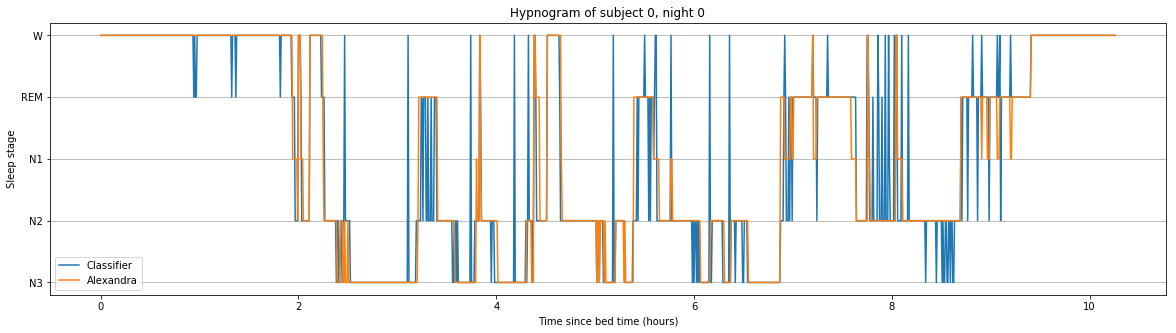

In [7]:
plt.rcParams["figure.figsize"] = (20,5)

print_hypnogram([y_pred, y], labels=["Classifier", "Alexandra"], subject=0, night=0)

## Results from models
____

### 1. RF
____

#### a) Not tuned
Hyperparameters configuration: `(n_estimators=100, others=default)`

```
              precision    recall  f1-score   support

           W       0.94      0.97      0.95       379
          N1       0.11      0.02      0.03        58
          N2       0.79      0.88      0.83       353
          N3       0.87      0.88      0.87       242
         REM       0.81      0.80      0.80       200

    accuracy                           0.85      1232
   macro avg       0.70      0.71      0.70      1232
weighted avg       0.82      0.85      0.83      1232

Agreement score (Cohen Kappa):  0.7987562656890558
```

#### b) Tuned version 1
____

Hyperparameters configuration: `(n_estimators=592, others=default)`

```
              precision    recall  f1-score   support

           W       0.93      0.97      0.95       379
          N1       0.20      0.02      0.03        58
          N2       0.77      0.87      0.82       353
          N3       0.86      0.87      0.86       242
         REM       0.81      0.78      0.80       200

    accuracy                           0.84      1232
   macro avg       0.72      0.70      0.69      1232
weighted avg       0.82      0.84      0.83      1232

Agreement score (Cohen Kappa):  0.7918637285539025


```

#### c) Tuned version 2
___

Hyperparameters configuration: `(n_estimators=592, max_depth=24, others=default)`

```
              precision    recall  f1-score   support

           W       0.93      0.97      0.95       379
          N1       0.20      0.02      0.03        58
          N2       0.78      0.88      0.82       353
          N3       0.87      0.86      0.87       242
         REM       0.81      0.78      0.79       200

    accuracy                           0.85      1232
   macro avg       0.72      0.70      0.69      1232
weighted avg       0.82      0.85      0.83      1232

Agreement score (Cohen Kappa):  0.7929001412044492
```

### 2. SVC
___

#### 1) Tuned version 1
___

Hyperparameters configuration: `(C=2.105, class_weight="balanced", others=default)`
Dimension reduction: `n_components=35`

```
              precision    recall  f1-score   support

           W       0.94      0.92      0.93       379
          N1       0.00      0.00      0.00        58
          N2       0.80      0.82      0.81       353
          N3       0.80      0.94      0.87       242
         REM       0.74      0.79      0.76       200

    accuracy                           0.83      1232
   macro avg       0.66      0.69      0.67      1232
weighted avg       0.80      0.83      0.81      1232

Agreement score (Cohen Kappa):  0.7727242779700145
```

### 3. KNN
___

Hyperparameters configuration: `weights='uniform', n_neighbors=300, leaf_size=100, metric='chebyshev',`
Dimension reduction: `LDA(n_components=default)`

```
              precision    recall  f1-score   support

           W       0.92      0.89      0.91       379
          N1       0.00      0.00      0.00        58
          N2       0.83      0.83      0.83       353
          N3       0.76      0.93      0.83       242
         REM       0.77      0.83      0.80       200

    accuracy                           0.83      1232
   macro avg       0.66      0.70      0.67      1232
weighted avg       0.80      0.83      0.81      1232

Agreement score (Cohen Kappa):  0.7739705524768276
```

### 4. Voting classifier
___

#### 1. Not tuned
___
```
              precision    recall  f1-score   support

           W       0.93      0.95      0.94       379
          N1       0.00      0.00      0.00        58
          N2       0.82      0.86      0.84       353
          N3       0.84      0.93      0.88       242
         REM       0.78      0.81      0.80       200

    accuracy                           0.85      1232
   macro avg       0.67      0.71      0.69      1232
weighted avg       0.81      0.85      0.83      1232

Agreement score (Cohen Kappa):  0.8023524765880627
```

#### 2. Tuned (soft, RF-KNN, weights)
___
```
              precision    recall  f1-score   support

           W       0.94      0.96      0.95       379
          N1       0.20      0.02      0.03        58
          N2       0.79      0.87      0.83       353
          N3       0.87      0.89      0.88       242
         REM       0.79      0.80      0.80       200

    accuracy                           0.85      1232
   macro avg       0.72      0.71      0.70      1232
weighted avg       0.83      0.85      0.83      1232

Agreement score (Cohen Kappa):  0.8020247469066367
```

### 5. Gaussian NB
___

```
              precision    recall  f1-score   support

           W       0.92      0.90      0.91       379
          N1       0.00      0.00      0.00        58
          N2       0.80      0.81      0.81       353
          N3       0.77      0.90      0.83       242
         REM       0.73      0.80      0.76       200

    accuracy                           0.82      1232
   macro avg       0.65      0.68      0.66      1232
weighted avg       0.79      0.82      0.80      1232

Agreement score (Cohen Kappa):  0.7577343073075279
```

## Median filter
___

In [8]:
KERNEL_SIZE=3

y_medfilt_pred = medfilt(y_pred, kernel_size=KERNEL_SIZE)

[[369   0   3   0   7]
 [  2   1  27   0  28]
 [  2   2 320  28   1]
 [  0   0  23 219   0]
 [  0   0  33   0 167]]
              precision    recall  f1-score   support

           W       0.99      0.97      0.98       379
          N1       0.33      0.02      0.03        58
          N2       0.79      0.91      0.84       353
          N3       0.89      0.90      0.90       242
         REM       0.82      0.83      0.83       200

    accuracy                           0.87      1232
   macro avg       0.76      0.73      0.72      1232
weighted avg       0.85      0.87      0.86      1232

Agreement score (Cohen Kappa):  0.8303076750565739


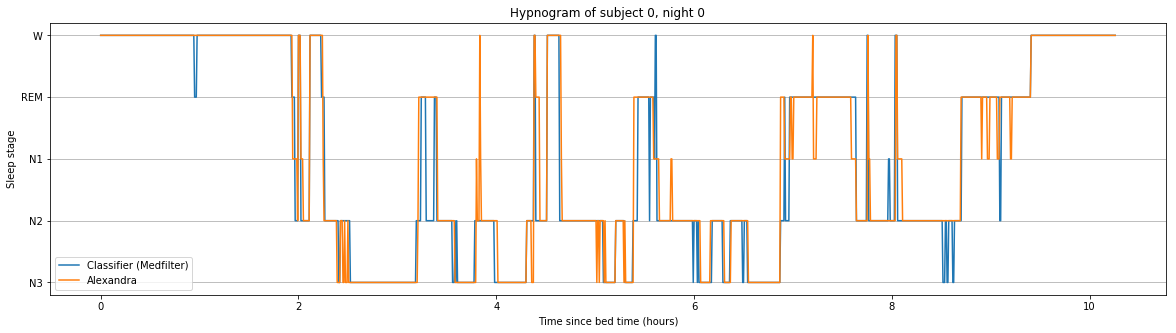

In [9]:
print(confusion_matrix(y, y_medfilt_pred))

print(classification_report(y, y_medfilt_pred, target_names=SLEEP_STAGES_VALUES.keys()))

print("Agreement score (Cohen Kappa): ", cohen_kappa_score(y, y_medfilt_pred))

print_hypnogram([y_medfilt_pred, y], labels=[ "Classifier (Medfilter)", "Alexandra"], subject=0, night=0)

## Hidden Markov Model
___

In [10]:
hmm_model = MultinomialHMM(n_components=N_STAGES)


hmm_model.emissionprob_ = np.load(f"{MODELS_DIR}/HMM_emissionprob.npy", allow_pickle=True)
hmm_model.startprob_ = np.load(f"{MODELS_DIR}/HMM_startprob.npy", allow_pickle=True)
hmm_model.transmat_ = np.load(f"{MODELS_DIR}/HMM_transmat.npy", allow_pickle=True)

y_hmm_pred = hmm_model.predict(y_pred.reshape(-1, 1))

[[367   4   7   0   1]
 [  0   7  21   0  30]
 [  0   1 305  47   0]
 [  0   0  18 224   0]
 [  0   0  30   0 170]]
              precision    recall  f1-score   support

           W       1.00      0.97      0.98       379
          N1       0.58      0.12      0.20        58
          N2       0.80      0.86      0.83       353
          N3       0.83      0.93      0.87       242
         REM       0.85      0.85      0.85       200

    accuracy                           0.87      1232
   macro avg       0.81      0.75      0.75      1232
weighted avg       0.86      0.87      0.86      1232

Agreement score (Cohen Kappa):  0.8278301223456617


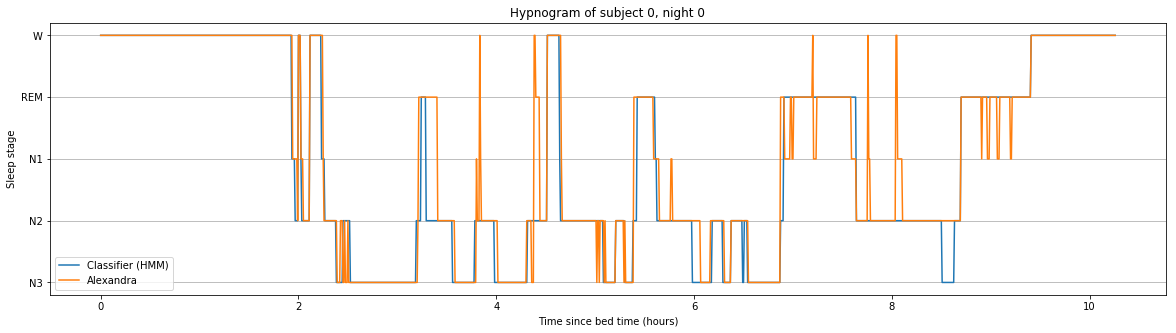

In [11]:
print(confusion_matrix(y, y_hmm_pred))

print(classification_report(y, y_hmm_pred, target_names=SLEEP_STAGES_VALUES.keys()))

print("Agreement score (Cohen Kappa): ", cohen_kappa_score(y, y_hmm_pred))

print_hypnogram([y_hmm_pred, y], labels=[ "Classifier (HMM)", "Alexandra"], subject=0, night=0)